This project consists of three parts:
1. Model creation - finding the best model to predict gross innual income for AirBNB's in LA
2. API integration - utilizing realtor.com API to input homes for sale into the model
3. Calculating potential Cash-on-Cash return for these homes.

In [3]:
!pip install kagglehub

In [4]:
import kagglehub
import pandas as pd
import os

# Download latest version
path = kagglehub.dataset_download("sauravilalge/los-angeles-airbnb-open-data")
print("Path to dataset files:", path)

# Construct the correct file path using os.path.join
file_path = os.path.join(path, 'listings.csv') # Use os.path.join to create the file path

# Now read the CSV
data = pd.read_csv(file_path)

# Save the DataFrame to a CSV file in the current directory
data.to_csv('airbnb_listings.csv', index=False)

100%|██████████| 181M/181M [00:02<00:00, 64.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/sauravilalge/los-angeles-airbnb-open-data/versions/2


In [5]:
# Step 1: Clean the 'price' column
data['price'] = data['price'].replace({'\$': '', ',': ''}, regex=True)

# Step 2: Strip any whitespace (if necessary)
data['price'] = data['price'].str.strip()

# Step 3: Convert the 'price' column to numeric
data['price'] = pd.to_numeric(data['price'])

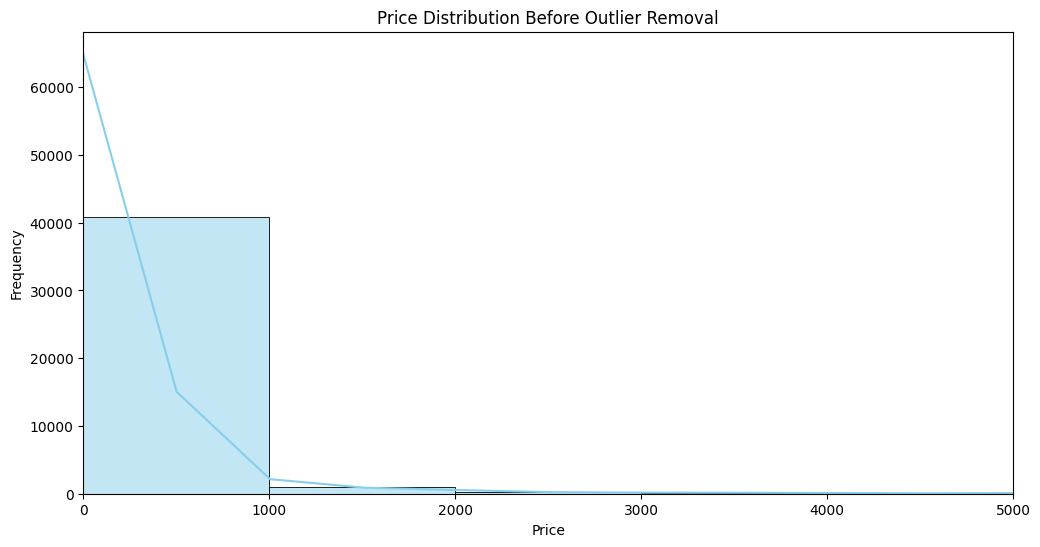

,price
count,42451.000000
mean,283.333962
std,1081.146729
min,0.000000
25%,89.000000
50%,145.000000
75%,246.000000
max,99999.000000


In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

price_summary = data['price'].describe()

# Visualizing price distribution before removing outliers
plt.figure(figsize=(12, 6))
sns.histplot(data['price'], bins=100, kde=True, color='skyblue')
plt.title('Price Distribution Before Outlier Removal')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.xlim(0, 5000)  # limiting x-axis to focus on lower range, extreme values would skew otherwise
plt.show()

price_summary

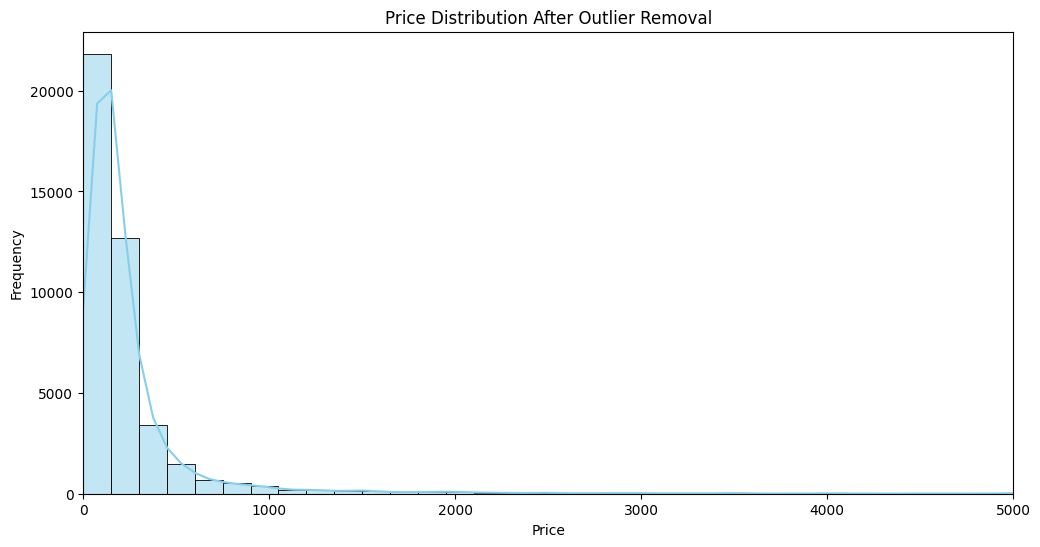

,price
count,42433.000000
mean,268.425777
std,590.813643
min,0.000000
25%,89.000000
50%,145.000000
75%,246.000000
max,15000.000000


In [7]:
# Create a new DataFrame excluding rows with price over 15,000 (inaccurate data)
filtered_data = data[data['price'] <= 15000]

# Visualizing price distribution after outlier removal
plt.figure(figsize=(12, 6))
sns.histplot(filtered_data['price'], bins=100, kde=True, color='skyblue')
plt.title('Price Distribution After Outlier Removal')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.xlim(0, 5000)  # again focusing on the range with most data
plt.show()

# Summary statistics for filtered data
filtered_price_summary = filtered_data['price'].describe()
filtered_price_summary

In [8]:
# We are only concerned with entire properties, not private rooms.

filtered_data = filtered_data[filtered_data['property_type'].str.contains('entire', case=False, na=False)]
filtered_price_summary = filtered_data['price'].describe()
filtered_price_summary

,price
count,29002.000000
mean,333.059030
std,633.885776
min,10.000000
25%,125.000000
50%,180.000000
75%,300.000000
max,15000.000000


In order to calculate gross anual income, we need to multiply the 'price' or average daily rate (ADR) by the occupancy rate. According to BNBCalc, the average Airbnb occupancy rate in Los Angeles is 75%.

In [9]:
# Add 'annual_gross_income' column

occupancy_rate = 0.75
days_in_year = 365
filtered_data['annual_gross_income'] = filtered_data['price'] * occupancy_rate * days_in_year

<ipython-input-9-155cd762ae8f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['annual_gross_income'] = filtered_data['price'] * occupancy_rate * days_in_year


Let's map the data that we have so we can see the distribution of AirBNB's in LA.

In [10]:
import plotly.express as px


fig = px.scatter_mapbox(
    filtered_data,
    lat="latitude",
    lon="longitude",
    hover_name="id",
    size="price",
    color_discrete_sequence=["blue"],
    title="Air BNB Listings in LA",
    zoom=6,
    height=600,
    opacity=0.05
)


fig.update_layout(
    mapbox_style="carto-positron",
    mapbox_center={"lat": 34.0522, "lon": -118.2437},
    margin={"r": 0, "t": 0, "l": 0, "b": 0}
)

fig.show()

Now its time to clean the 'amenities' feature.

In [11]:
# Count the unique amenities values

filtered_data['amenities_cleaned'] = filtered_data['amenities'].apply(lambda x: x.lower().split(','))
unique_amenities_count = filtered_data['amenities'].nunique()
print(unique_amenities_count)


26815


This is way too many unique values to input into our model.

According to AirDNA, pools, hot tubs, washer and dryers, and gyms add the greatest boost in Revenue per Available Room (RevPAR) compared to listings without these amenities.
So these are the 5 amenities that we will focus on in our model.

In [12]:
amenities_to_check = ['pool', 'hot tub', 'washer', 'dryer', 'gym']

for amenity in amenities_to_check:
  filtered_data[amenity] = filtered_data['amenities'].str.lower().str.contains(amenity)

# check to make sure our new columns got added to the data
columns_list = filtered_data.columns.tolist()
print(columns_list)

['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name', 'description', 'neighborhood_overview', 'picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'calendar_updated', 'has_availability', 'availability_30', 'availability_60', 'availability_90', 'availabil

Now its time to create a model that will predict the the gross annual income of a property on AirBNB.

In [13]:
# Selecting relevant features for modeling
features = [
    'bedrooms', 'property_type', 'latitude', 'longitude',
    'pool', 'washer', 'dryer', 'gym', 'hot tub'
]

Lets make sure there are no missing values in our features.

In [14]:
nan_counts = filtered_data[features].isna().sum()
print(nan_counts)

bedrooms         3098
property_type       0
latitude            0
longitude           0
pool                0
washer              0
dryer               0
gym                 0
hot tub             0
dtype: int64


We need to remove the observations in which the number of bedrooms is missing.

In [15]:
filtered_data = filtered_data.dropna(subset=['bedrooms'])
nan_counts = filtered_data[features].isna().sum()
print(nan_counts)

bedrooms         0
property_type    0
latitude         0
longitude        0
pool             0
washer           0
dryer            0
gym              0
hot tub          0
dtype: int64


**Linear** **Regression**

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# 1. Prepare the data:
# Select the features and target variable
X = filtered_data[features]
y = filtered_data['annual_gross_income']

# One-hot encode the 'property_type' column, since it's categorical
X = pd.get_dummies(X, columns=['property_type'], drop_first=True)

# 2. Split the data into training and testing sets:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # 80% for training, 20% for testing

# 3. Create and train the model:
model = LinearRegression()
model.fit(X_train, y_train)

# 4. Make predictions on the test set:
y_pred = model.predict(X_test)

# 5. Evaluate the model:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 22208124709.02073
R-squared: 0.32785994575319877


Ok so Linear Regression did not perform so well, lets try some non-linear models.

Training Decision Tree...
Training Random Forest...
Training Support Vector Regression...
Training Extra Trees...
Training K-Nearest Neighbors...


<ipython-input-17-152f7d70c89b>:43: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

<ipython-input-17-152f7d70c89b>:48: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



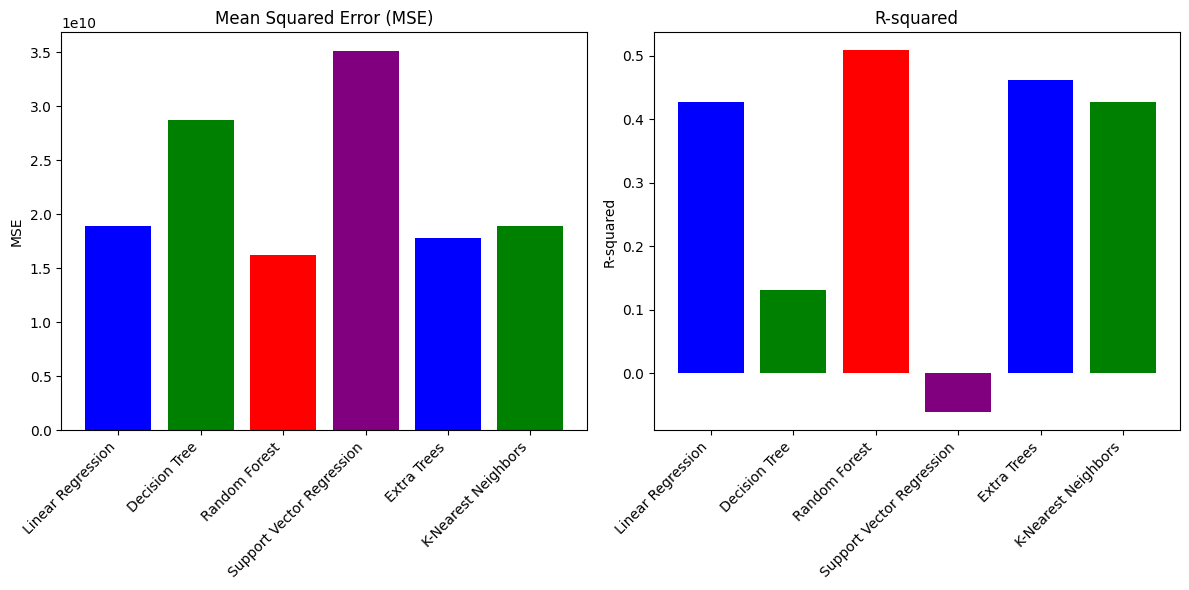

In [17]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor

# Define a list of non-linear models to try:
non_linear_models = {
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Support Vector Regression": SVR(),
    "Extra Trees": ExtraTreesRegressor(),
    "K-Nearest Neighbors": KNeighborsRegressor()
}

# Train and evaluate each non-linear model:
results = {}
for model_name, model in non_linear_models.items():
    print(f"Training {model_name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[model_name] = {"MSE": mse, "R-squared": r2}

# --- Plotting the results ---

model_names = list(results.keys())
mse_values = [results[name]['MSE'] for name in model_names]
r2_values = [results[name]['R-squared'] for name in model_names]

# Add Linear Regression results to the plot data
model_names.insert(0, "Linear Regression")  # Add at the beginning
mse_values.insert(0, mse)  # Add at the beginning
r2_values.insert(0, r2)  # Add at the beginning

# Create the plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.bar(model_names, mse_values, color=['blue', 'green', 'red', 'purple'])
ax1.set_title('Mean Squared Error (MSE)')
ax1.set_ylabel('MSE')
ax1.set_xticklabels(model_names, rotation=45, ha='right')

ax2.bar(model_names, r2_values, color=['blue', 'green', 'red', 'purple'])
ax2.set_title('R-squared')
ax2.set_ylabel('R-squared')
ax2.set_xticklabels(model_names, rotation=45, ha='right')

plt.tight_layout()

Out of the models we have chosen, the random forest model has the lowest mse and explains the greatest amount of variation in the data.